# Step 0: Preparation

## Library installation

In [ ]:
## Install twint
!git clone --depth=1 https://github.com/twintproject/twint.git
%cd twint
%pip install . -r requirements.txt
%cd ..

In [ ]:
!pip install spacy==3.0
!pip install tweepy
!pip install wordcloud==1.8.1

In [ ]:
!pip install wheel
!pip install twarc

In [ ]:
!pip install -U gensim

In [ ]:
!pip install nltk

## Library import

In [5]:
import os
import csv
import html
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import json

In [6]:
from datetime import datetime, timedelta
from tqdm import tqdm

In [7]:
import twint
import nest_asyncio
nest_asyncio.apply()

from twarc import Twarc

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Step 1: Download Twitter data (DO NOT RUN)

The following cells show our data collection process.

Twitter ids were extracted using the "twint" package. The process collects all tweets containing the word "Lockdown" and stores them in CSV files containing a week's worth of data. Additional filters were set for the tweets to have "United Kingdom" as a nearby location.

The start date for the data collection process is 2nd of March 2020 and the end date is 22nd of March 2021.

### NOTE: the data for the next two steps can be found and downloaded from the following location https://drive.google.com/drive/folders/1gjZZHHOpQRh6TwM1R_x0PgBemrhj5tlY?usp=sharing

In [ ]:
# import datetime

weekly_dates = []

start_date = datetime.date(2020, 3, 2)
end_date = datetime.date(2021, 3, 22)
delta = datetime.timedelta(days=7)
while start_date <= end_date:
    weekly_dates.append(start_date)
    start_date += delta
# weekly_dates.append(start_date)

print(weekly_dates)

In [ ]:
for index in range(len(weekly_dates) - 1):
    c = twint.Config()
    c.Search = "Lockdown"
    c.Custom["tweet"] = ["id"]
    c.Output = "data/" + weekly_dates[index].strftime("%Y-%m-%d") + ".csv"
    c.Store_csv = True

    c.Near = "United Kingdom"  #to set nearby location

    c.Since = weekly_dates[index].strftime("%Y-%m-%d")  #YYYY-MM-DD
    c.Until = weekly_dates[index + 1].strftime("%Y-%m-%d")

    twint.run.Search(c)

# Step 2: Load and hydrate twitter ids (DO NOT RUN)

In [ ]:
## ALTERNATIVE credentials

# consumer_key = "cy46eEMheYBASNIj982xnHONj"
# consumer_secret = "AkL5JNl7OLijz7125NjzAp8Fk4ViaUiR8GYrRAIckqduVj7Fx4"

# access_token = "1959283232-aCyAAjeCBp8cvvnpsTF4gJLnsdC7nZddUWaZJtu"
# access_token_secret = "tNpfXr2Htwzscf2XUhLC9bvNCtEFoNZmwquqrLp7SKBCq"

In [168]:
# Twitter credentials
consumer_key = "hPXFUlTG4BOMjzJpNOtT3BHn9"
consumer_secret = "Bo59uO5Z2a7fxDMmWAts1O6GurF73iIdHnYYzFzgeqew0Oe17P"

access_token = "1844121-0QhEfcPyRbBWPdOPg4EsGaRZLT7LYQO5jd4rFJmW9k"
access_token_secret = "IUCjfGxH1vUgOsYpFZX0KqHm3K2MUGhNLphQQY5ncGaII"

In [ ]:
# Define rehydrator
t = Twarc(consumer_key, consumer_secret, access_token, access_token_secret)

In [169]:
# files containing twitter ids
files_to_hydrate = [file for file in os.listdir("data") if file.startswith("20")]

### Hydrate twitter ids, create dataframes and store in CSV files.

Each CSV file corresponds to a week's worth of data in the form of twitter IDs. For each twitter id, hydrate the data and extract all fields returned by twitter's API.

Tweets are filtered to only keep the most relevant data. First,  tweets are filtered by language so that only English tweets are kept ("lang" field is "en"). Then, the country is inspected, to only keep posts which have "United Kingdom" as their geo-tagged country, or any tweet which was not tagged at all (empty country, ""), all other countries being discarded.

From the final dataframe, the language column is removed.

In original format, hashtags are returned as json objects containing the text of the hashtag and the location in the original post. For this column, only the hashtag text is kept.

The date and time are extracted from the "created_at" column. This contains raw text which is converted to a datetime format and all necessary information is after extracted.

The coordinates column contains a list of 4 coordinate pairs corresponding to a rectangle giving the area (location).

Cleaned dataframes are stored locally in a directory called "hydrated" for easy access. Final files contain relevant datasets for each week.

<b>Note: the hydration process takes ~2 hours to complete</b>

In [170]:
for index in tqdm(range(len(files_to_hydrate))):
    
    # get file name
    file_name = files_to_hydrate[index]
    
    if file_name not in os.listdir("data/hydrated"):
    
        path_file = os.path.join(os.getcwd(), "data", file_name)
        # load twitter ids from file
        with open(path_file, newline='') as csvfile:
            df = pd.DataFrame(csv.DictReader(csvfile))
        # convert ids to list
        tweets_id_list = df.id.tolist()

        # create dataset and initialise lists for columns
        data = pd.DataFrame()
        created_at = []
        text = []
        hashtags = []
        country = []
        location_name = []
        location_coordinates = []
        lang = []

        # Hydrate every tweet and extract relevant information
        for tweet in t.hydrate(tweets_id_list):
            created_at.append(tweet["created_at"])
            text.append(tweet["full_text"])
            hashtags.append(tweet["entities"]["hashtags"])
            lang.append(tweet["lang"])
            try:
                country.append(tweet["place"]["country"])
            except:
                country.append("")
            try:
                location_name.append(tweet["place"]["full_name"])
            except:
                location_name.append("")
            try:
                location_coordinates.append(tweet["place"]["bounding_box"]["coordinates"]) # will be a list
            except:
                location_coordinates.append([])

        # create dataframe columns
        data["created_at"] = created_at
        data["text"] = text
        data["hashtags"] = hashtags
        data["country"] = country
        data["location_name"] = location_name
        data["location_coordinates"] = location_coordinates
        data["lang"] = lang

        # Filter

        # only keep tweets in English and which have the country United Kingdom or untagged
        data = data[(data["lang"] == "en") & ((data["country"] == "United Kingdom") | (data["country"] == ""))]

        # drop language column
        data = data.drop(columns=["lang"])
        data = data.reset_index(drop=True) # reset indices

        # Extract hashtags
        extracted_hashtags = []

        for i in data["hashtags"]:
            if len(i):
                extracted_hashtags.append([element["text"] for element in i])
            else:
                extracted_hashtags.append(i)

        # update hashtags column
        data["hashtags"] = extracted_hashtags

        # Extract date and time
        dates = []
        times = []

        for c in data["created_at"]:
            date_time_obj = datetime.strptime(c, '%a %b %d %H:%M:%S %z %Y')
            dates.append(str(date_time_obj.date()))
            times.append(str(date_time_obj.time()))

        # create new columns
        data["date"] = dates
        data["time"] = times
        
        # drop old "created_at" column
        data = data.drop(columns=["created_at"])
        data = data.reset_index(drop=True)

        # Store final dataframe to file
        file_name = f"hydrated/{file_name}"

        file_location = os.path.join("data", file_name)
        data.to_csv(file_location, index=False)

100%|██████████| 55/55 [1:56:14<00:00, 126.81s/it]


# Step 3: Load dataset (begin here)

Here begins the analysis. The data is loaded from a local directory ("hydrated"), preprocessed and used for analysis.

### Load all necessary files - to be implemented

In [11]:
# Load all files into memory (create a dataframe containing all tweets)
def get_week_dates(date_bounds):
    date1 = datetime.strptime(date_bounds["start_date"], '%Y-%m-%d').date()
    
    if date_bounds["end_date"] != "":
        date2 = datetime.strptime(date_bounds["end_date"], '%Y-%m-%d').date()
        for n in range(int ((date2 - date1).days)+1):
            yield date1 + timedelta(n)
    else:
        yield date1

In [12]:
lockdown_1_announcement = {"start_date":"2020-03-26", "end_date":""}
lockdown_1 = {"start_date":"2020-03-26", "end_date":"2020-05-10"}

lockdown_2_announcement = {"start_date":"2020-10-31", "end_date":""}
lockdown_2 = {"start_date":"2020-11-05", "end_date":"2020-12-02"}

lockdown_3_announcement = {"start_date":"2021-01-04", "end_date":""}
lockdown_3 = {"start_date":"2021-01-06", "end_date":"2021-03-22"}

In [13]:
from glob import glob

In [14]:
all_files = sorted(glob('data/hydrated/20*.csv'))

In [15]:
# concatenate all files containing tweets and reset the index of all samples
data = pd.concat(
    (pd.read_csv(file, lineterminator='\n').assign(filename = file)
     for file in all_files)
).reset_index(drop=True)

#### Dataset for the whole year

In [16]:
data.head()

text           hashtags  \
0  @JulienHoez @YouTube We have decided we are go...                 []   
1  supposed to be goin Venice in 2 week &amp; @ea...                 []   
2  Because Milan and Venice airports are open , e...                 []   
3  *SOUND ON*\nFor Francesca who is finding life ...  ['relax', 'rest']   
4                Venice trip looks screwed #lockdown       ['lockdown']   

          country             location_name  \
0  United Kingdom        Strood, South East   
1  United Kingdom           Oldham, England   
2  United Kingdom  Scotland, United Kingdom   
3  United Kingdom      Shaftesbury, England   
4  United Kingdom           Marple, England   

                                location_coordinates        date      time  \
0  [[[0.4496776, 51.3828931], [0.499886, 51.38289...  2020-03-08  10:02:05   
1  [[[-2.185708, 53.492866], [-2.048031, 53.49286...  2020-03-08  10:13:56   
2  [[[-7.66085699743185, 54.6336309570711], [-0.7...  2020-03-08  10:14:27   
3  [[[-2.2152049, 50.997428], [-2.1774652, 50.997...  2020-03-08  10:25:06   
4  [[[-2.090605, 53.380423], [-2.0507618, 53.3804...  2020-03-08  10:42:41   

                       filename  
0  data/hydrated/2020-03-02.csv  
1  data/hydrated/2020-03-02.csv  
2  data/hydrated/2020-03-02.csv  
3  data/hydrated/2020-03-02.csv  
4  data/hydrated/2020-03-02.csv

In [17]:
len(data)

573272

#### Dataset for each lockdown and announcement dat

In [18]:
def create_df_by_dates(df, dates):
    return df[df["date"].isin([
              d.strftime("%Y-%m-%d")
              for d in get_week_dates(dates)]
              )].sort_values(by=['date']).reset_index(drop=True)

In [19]:
data_lockdown_1 = create_df_by_dates(data, lockdown_1)
data_lockdown_2 = create_df_by_dates(data, lockdown_2)
data_lockdown_3 = create_df_by_dates(data, lockdown_3)
data_lockdown_announcement_1 = create_df_by_dates(data, lockdown_1_announcement)
data_lockdown_announcement_2 = create_df_by_dates(data, lockdown_2_announcement)
data_lockdown_announcement_3 = create_df_by_dates(data, lockdown_3_announcement)

# Step 4: Preprocess tweets

Methods for data preprocessing and cleaning

In [20]:
print(len(data["text"]))
print(len(data["text"].unique()))

573272
569778


In [21]:
#Cleaning @,#,websites, and RT
def clean_tweet(text):
    # remove URLs
    text = re.sub('https?:\/\/\S+','',text) # add www.
    # remove twitter handles
    text = re.sub(r'@[A-Za-z0-9_.,\-]+','',text)
    # remvove hashtags
    text = re.sub(r'#','',text)
    # remove retweets
    text = re.sub(r'RT[\S]+','',text)
    # remove unnecessary line breaks
    text = re.sub(r'\n', '', text)
    
    # lowercase
    text = text.lower()
    # remove punctuation
    text = re.sub('[,\\.!?]', ' ', text)
    
    # strip text of spaces
    text = text.strip()
    # remove duplicate whitespaces
    text = re.sub(' +', ' ', text)
    # Escape HTML characters e.g. `&amp;`
    text = html.unescape(text)
    
    return text

In [22]:
data['text'] = data['text'].apply(clean_tweet)

In [23]:
data.head()

text           hashtags  \
0  we have decided we are going to write off the ...                 []   
1  supposed to be goin venice in 2 week & still f...                 []   
2  because milan and venice airports are open eve...                 []   
3  *sound on*for francesca who is finding life ve...  ['relax', 'rest']   
4                 venice trip looks screwed lockdown       ['lockdown']   

          country             location_name  \
0  United Kingdom        Strood, South East   
1  United Kingdom           Oldham, England   
2  United Kingdom  Scotland, United Kingdom   
3  United Kingdom      Shaftesbury, England   
4  United Kingdom           Marple, England   

                                location_coordinates        date      time  \
0  [[[0.4496776, 51.3828931], [0.499886, 51.38289...  2020-03-08  10:02:05   
1  [[[-2.185708, 53.492866], [-2.048031, 53.49286...  2020-03-08  10:13:56   
2  [[[-7.66085699743185, 54.6336309570711], [-0.7...  2020-03-08  10:14:27   
3  [[[-2.2152049, 50.997428], [-2.1774652, 50.997...  2020-03-08  10:25:06   
4  [[[-2.090605, 53.380423], [-2.0507618, 53.3804...  2020-03-08  10:42:41   

                       filename  
0  data/hydrated/2020-03-02.csv  
1  data/hydrated/2020-03-02.csv  
2  data/hydrated/2020-03-02.csv  
3  data/hydrated/2020-03-02.csv  
4  data/hydrated/2020-03-02.csv

In [24]:
data["text"][0]

'we have decided we are going to write off the airline tickets given that milan has now gone into lockdown what it’s like in france at the moment'

#### Clean all lockdown subsets

In [25]:
data_lockdown_1['text'] = data_lockdown_1['text'].apply(clean_tweet)
data_lockdown_2['text'] = data_lockdown_2['text'].apply(clean_tweet)
data_lockdown_3['text'] = data_lockdown_3['text'].apply(clean_tweet)
data_lockdown_announcement_1['text'] = data_lockdown_announcement_1['text'].apply(clean_tweet)
data_lockdown_announcement_2['text'] = data_lockdown_announcement_2['text'].apply(clean_tweet)
data_lockdown_announcement_3['text'] = data_lockdown_announcement_3['text'].apply(clean_tweet)

# Step 5: Text analysis on unique tweets

### Extract unique tweets

In [26]:
def extract_unique_tweets(dataset):
    unique_tweets = list(set(list(dataset['text'])))
    unique_tweets = [t for t in unique_tweets if t]
    
    return unique_tweets

In [27]:
unique_tweets = extract_unique_tweets(data)

In [28]:
len(unique_tweets)

559178

In [29]:
unique_tweets[0]

"the issue/incident should be highlighted every time lockdown compliance is raised the contempt shown by cummings supported by the government affects people's attitude"

## Word Cloud

The following methods create word clouds for every lockdown dataset and print top words 

In [30]:
import collections

In [31]:
def visualise_word_cloud(dataset, max_words=1000):
    
    # produce unique tweets
    unique_tweets = list(set(list(dataset['text'])))
    unique_tweets = [t for t in unique_tweets if t]
        
    # join the words of the different tweets together into one string
    long_string = ' '.join(unique_tweets)
    new_long_string = ' '.join(set(long_string.split(" ")))

    # create a WordCloud object
    wordcloud = WordCloud(background_color="white", 
                          max_words=max_words, 
                          stopwords=STOPWORDS,
                          normalize_plurals=False,
                          contour_width=3, 
                          contour_color='steelblue', 
                          min_word_length=3,
                          collocation_threshold=20)

    # generate a word cloud
    wordcloud.generate(new_long_string)

    # visualize the word cloud
    wordcloud.to_image()
    top_words = list(wordcloud.words_.keys())[:200]
    print(top_words)
    
    # Display the generated image:
    plt.figure(figsize=(13,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#### Produce wordcloud for all year's tweets

['lockdown', 'day', 'covid', 'now', 'non', 'today', 'time', 'one', 'pre', 'home', 'well', 'self', 'stay', 'post', 'work', 'people', 'week', 'coronavirus', 'new', 'happy', 'anti', 'please', 'hope', 'life', 'london', 'thanks', 'free', 'covid19', 'thank', 'let', 'good', 'safe', 'back', 'year', 'love', 'see', 'family', 'open', 'long', 'another', 'lock', 'soon', 'great', 'rules', 'first', 'end', 'check', 'boris', 'full', 'read', 'birthday', 'will', 'staysafe', 'based', 'school', 'watch', 'isolation', 'government', 'nhs', 'live', 'support', 'don', 'looking', 'run', 'walk', 'social', 'keep', 'take', 'yes', 'hair', 'house', 'march', 'two', 'everyone', 'best', 'news', 'working', 'stayhome', 'garden', 'pro', 'last', 'look', 'food', 'shop', 'book', 'weeks', 'world', 'party', 'friends', 'zoom', 'sunday', 'health', 'half', 'ish', 'style', 'care', 'tonight', 'exercise', 'going', 'order', 'may', 'join', 'help', 'link', 'music', 'man', 'weekend', 'tomorrow', 'done', 'days', 'call', 'better', 'enjoy', 

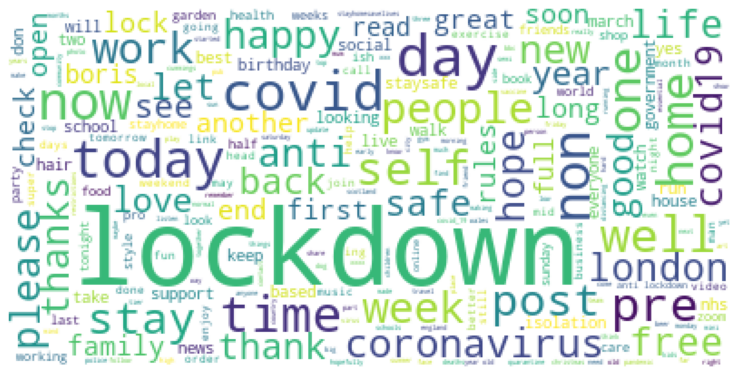

In [32]:
visualise_word_cloud(data)

### Lockdown 1 announcement

['lockdown', 'day', 'today', 'post', 'self', 'life', 'year', 'covid2019', 'hope', 'week', 'stay', 'fun', 'home', 'isolation', 'work', 'time', 'quarantine', 'will', 'pre', 'non', 'covid', 'people', 'country', 'right', 'distancing', 'now', 'update', 'yesterday', 'rules', 'live', 'law', 'insta', 'next', 'three', 'everyone', 'lost', 'happy', 'man', '30pm', 'one', 'lock', 'coronavirus', 'challenge', 'red', 'new', 'covid19uk', 'tree', 'elaine', 'send', 'herd', 'evening', 'isolating', 'hair', 'sun', 'look', 'link', 'london', 'yes', 'instagram', 'dad', 'well', 'mother', 'state', 'distance', 'worker', 'whatsapp', 'corona', 'love', 'covid_19', 'coffee', 'banana', 'party', 'let', 'support', 'children', 'walk', 'high', 'see', 'video', 'stayhome', 'line', 'france', 'wash', 'friend', 'think', 'sea', 'birthday', 'breaking', 'travel', 'days', 'daughter', 'anti', 'watching', 'run', 'news', 'essentials', 'working', 'thephotohour', 'follow', 'blackpool', 'clapfornhs', 'queen', 'silly', 'clock', 'saw', 'f

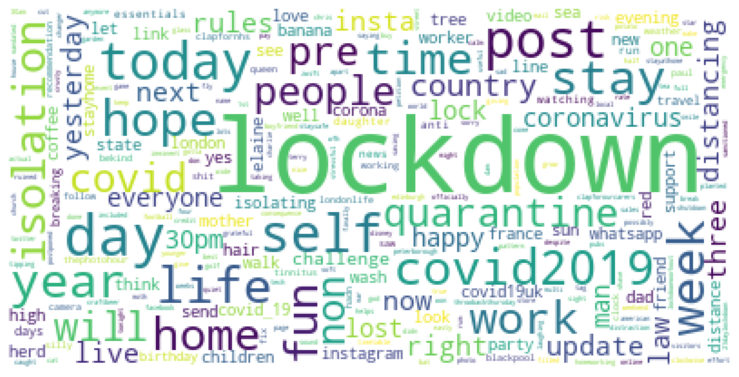

In [33]:
visualise_word_cloud(data_lockdown_announcement_1)

### Lockdown 1

['lockdown', 'day', 'today', 'self', 'coronavirus', 'home', 'time', 'one', 'now', 'stay', 'well', 'non', 'covid', 'covid19', 'work', 'pre', 'hope', 'life', 'people', 'new', 'post', 'week', 'staysafe', 'please', 'safe', 'stayhome', 'happy', 'stayhomesavelives', 'thank', 'let', 'london', 'thanks', 'free', 'good', 'garden', 'lock', 'family', 'anti', 'love', 'house', 'check', 'friends', 'keep', 'read', 'sunday', 'weeks', 'back', 'quarantine', 'another', 'isolation', 'best', 'great', 'long', 'run', 'watch', 'hair', 'live', 'walk', 'birthday', 'may', 'year', 'government', 'social', 'everyone', 'end', 'nhs', 'see', 'care', 'soon', 'exercise', 'full', 'old', 'half', 'world', 'will', 'easter', 'first', 'man', 'help', 'coronaviruslockdown', 'made', 'don', 'weekend', 'music', 'things', 'looking', 'covid_19', 'going', 'days', 'far', 'shop', 'tonight', 'night', 'two', 'school', 'working', 'take', 'video', 'head', 'anyone', 'sun', 'book', 'three', 'better', 'dog', 'essential', 'right', 'still', 'yes

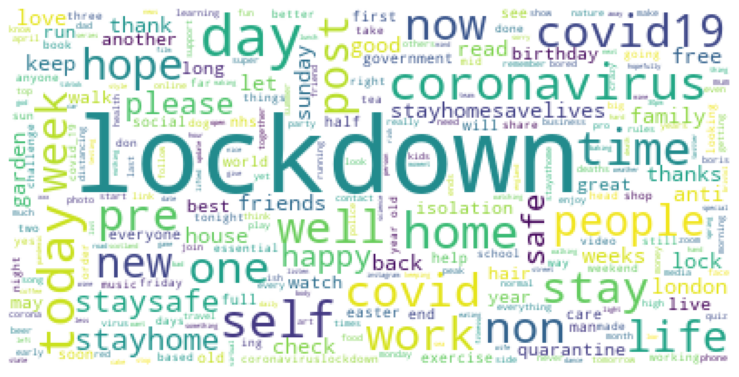

In [34]:
visualise_word_cloud(data_lockdown_1)

### Lockdown 2 announcement

['lockdown', 'non', 'covid', 'boris', 'lockdown2', 'england', 'pre', 'time', 'schools', 'now', 'week', 'month', 'national', 'one', 'self', 'christmas', 'circuit', 'halloween', 'wales', 'tier', 'see', 'school', 'post', 'half', 'thursday', 'break', 'fuck', 'johnson', 'stay', 'let', 'minister', 'day', 'yet', 'government', 'right', 'family', 'breaker', 'today', 'public', 'full', 'virus', 'cummings', 'well', 'wave', 'essential', 'weeks', 'please', 'open', 'tonight', 'hope', 'wrong', 'people', 'everyone', 'save', 'xmas', 'free', 'call', 'long', 'evening', 'know', 'wide', 'saturday', 'ups', 'say', 'sept', 'eat', 'restrictions', 'coming', 'kids', 'shit', 'shops', 'london', 'hospitality', 'happy', '2nd', 'morning', 'economy', 'thank', 'bojo', 'last', 'scotland', 'deaths', 'september', 'book', 'leak', 'work', 'life', 'run', 'think', 'pro', 'old', 'everything', 'restaurants', 'pubs', 'read', 'lock', 'english', 'mid', 'turn', 'pub', 'borishasfailedtheuk', 'normal', 'conference', 'bubble', 'labour'

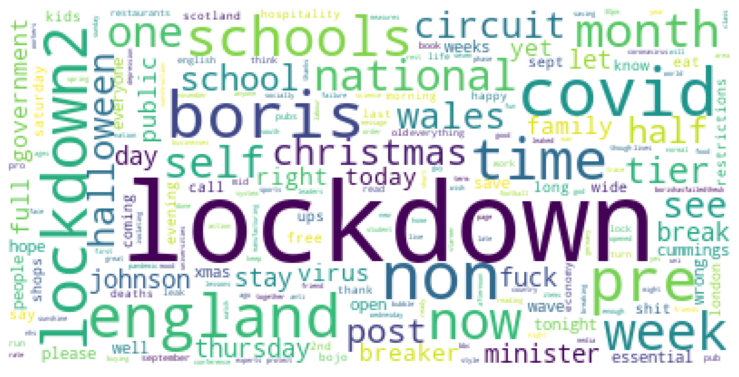

In [35]:
visualise_word_cloud(data_lockdown_announcement_2)

### Lockdown 2

['lockdown', 'covid', 'pre', 'day', 'non', 'anti', 'home', 'open', 'time', 'one', 'week', 'isolation', 'now', 'self', 'new', 'free', 'stay', 'christmas', 'today', 'thank', 'lockdown2', 'post', 'please', 'happy', 'hope', 'well', 'back', 'support', 'work', 'let', 'london', 'family', 'call', 'life', 'people', 'book', 'monday', 'saturday', 'live', 'december', 'year', 'working', 'boris', 'released', 'sunday', 'safe', 'much', 'england', 'lock', 'tonight', 'shop', 'love', 'see', 'november', 'tier', 'month', '30pm', 'coronavirus', 'world', 'school', 'good', 'news', 'winter', 'together', '9pm', 'friday', 'everyone', 'may', 'don', 'half', 'restrictions', 'remember', 'morning', 'walk', 'take', 'gym', 'run', 'click', 'mid', 'night', 'two', 'keep', 'local', 'first', 'risk', 'pandemic', 'delivery', 'watch', 'long', 'rules', 'tomorrow', 'fun', 'big', 'normal', 'birthday', 'great', 'business', 'travel', 'tiers', 'help', 'pub', 'essential', 'online', 'man', 'mask', 'bbc', 'country', 'march', 'going', '

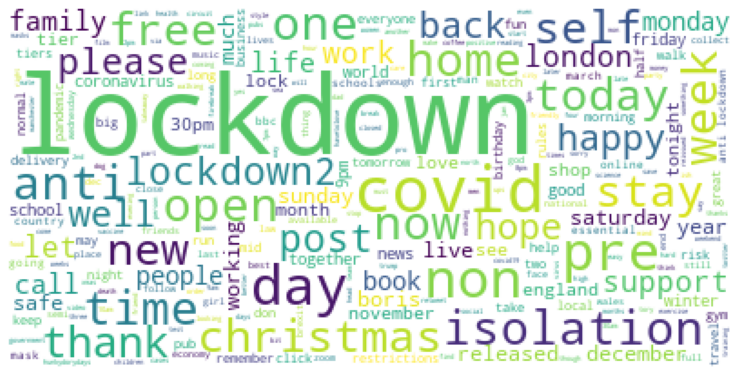

In [36]:
visualise_word_cloud(data_lockdown_2)

### Lockdown 3 announcement

['lockdown', 'covid', 'now', 'new', 'march', 'home', 'boris', 'scotland', 'england', 'year', 'national', 'april', 'nationallockdown', 'schools', 'well', 'work', 'tier', 'tonight', 'please', 'open', 'time', 'school', 'day', 'stay', 'pre', 'may', 'non', 'essential', 'working', 'full', 'vulnerable', 'summer', 'safe', 'one', 'let', 'tomorrow', 'happy', 'government', 'everyone', 'house', 'mid', 'trace', 'term', 'following', 'month', 'johnson', 'take', 'today', 'vaccine', 'xmas', 'country', 'level', 'christmas', 'live', 'wide', 'february', 'league', 'sturgeon', 'possible', 'post', 'fuck', 'rules', 'learning', 'ish', 'long', 'closed', 'self', 'good', 'hopefully', 'key', 'update', 'world', 'lockdown3', 'life', 'tougher', 'friends', 'iii', 'half', 'week', 'next', 'call', 'zoom', 'read', 'workers', 'etc', 'keep', 'monday', 'lives', 'thanks', 'fun', 'eat', 'help', 'yes', 'don', 'australia', 'elite', 'shut', 'already', 'contact', 'lock', 'children', 'midnight', 'govt', 'guidance', 'normality', 'mi

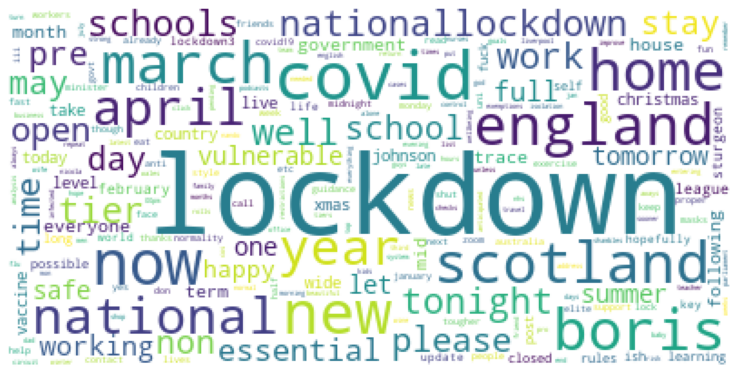

In [37]:
visualise_word_cloud(data_lockdown_announcement_3)

### Lockdown 3

['lockdown', 'covid', 'anti', 'day', 'non', 'self', 'one', 'pre', 'time', 'now', 'anti lockdown', 'today', 'home', 'well', 'life', 'free', 'london', 'pro', 'people', 'year', 'happy', 'work', 'week', 'post', 'march', 'long', 'birthday', 'vaccine', 'new', 'good', 'please', 'let', 'end', 'pandemic', 'hope', 'stay', 'government', 'love', 'month', 'open', 'thank', 'police', 'soon', 'back', 'read', 'rules', 'thanks', 'mid', 'see', 'school', 'live', 'full', 'party', 'deaths', 'watch', 'great', 'half', 'world', 'another', 'protest', 'friends', 'based', 'lock', 'yes', 'pub', 'lockdown2021', 'last', 'protests', 'health', 'virus', 'family', 'hard', 'weekend', 'covid19', 'may', 'sunday', 'april', 'look', 'will', 'masks', 'check', 'night', 'everyone', 'news', 'right', 'friday', 'days', 'better', 'essential', 'order', 'take', 'fun', 'best', 'three', 'walk', 'local', 'freedom', 'winter', 'spring', 'longer', 'nhs', 'man', 'cases', 'running', 'food', 'months', 'hair', 'play', 'working', 'january', 'tom

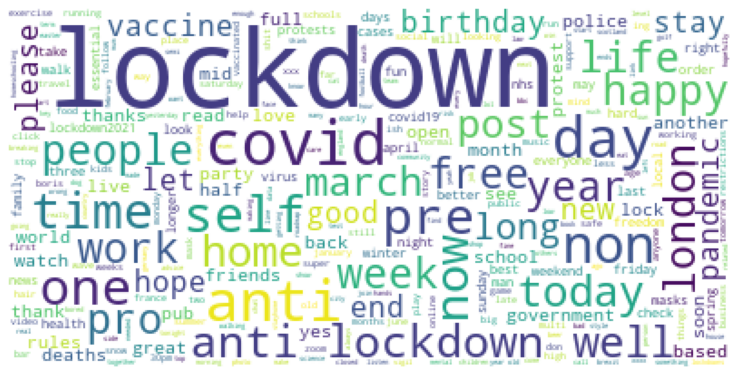

In [38]:
visualise_word_cloud(data_lockdown_3)

# Step 6: Topic Modelling

## LDA

For topic modelling, the LDA pachage is used. Stopwords and additional tokens (2 letter tokens) resulted from preprocessing are removed for cleaner results. LDA was chosen as a modelling method (as opposed to Biterm) due to its speed in processing, although results might be inferior due to poorer disambiguation.

In [30]:
!pip install --upgrade pip
!pip install pyldavis

In [31]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [32]:
from pprint import pprint

# import pyLDAvis.gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [33]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'amp', 'd', 'll', 's', 'th', 'oh'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
        if word not in stop_words] for doc in texts]

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Prepare data for topic modelling

In [34]:
def generate_topics(dataset, file_name, number_topics=7, number_words=20):
    
    # extract all words from the dataset
    data_words = list(sent_to_words(
        extract_unique_tweets(dataset)
    ))
    
    # remove stop words
    data_words = remove_stopwords(data_words)
    # create a dictionary
    id2word = corpora.Dictionary(data_words)
    # create a corpus
    texts = data_words
    # convert the corpus into a BoW representation
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # set number of topics
    num_topics = number_topics
    # build an LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

    doc_lda = lda_model[corpus]
    
    # Visualise the topics and store files
    LDAvis_data_filepath = os.path.join('./'+file_name+str(num_topics))

    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
#     LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

    pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')

    # print topics
    LDAvis_prepared

    x=lda_model.show_topics(number_topics, number_words,formatted=False)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
    
    #Below Code Prints Only Words 
    for topic,words in topics_words:
        print(", ".join(words))

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Top 7 topics - Lockdown 1 Announcement

In [35]:
generate_topics(data_lockdown_announcement_1, 'announcement-1')

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lockdown, time, home, day, covid, still, people, lock, first, everyone, work, us, london, going, make, stay, new, see, uk, weeks
lockdown, day, people, lock, today, take, get, like, coronavirus, need, one, much, going, please, would, country, time, done, go, house
lockdown, day, much, coronavirus, covid, like, home, stay, got, well, hope, time, people, uk, lock, new, since, even, know, getting
lockdown, day, get, covid, uk, people, today, lock, got, time, week, going, coronavirus, home, go, days, work, us, working, like
lockdown, time, day, lock, one, think, hope, keep, get, love, go, people, good, would, going, even, like, could, free, something
lockdown, lock, day, people, one, going, go, get, like, stay, covid, home, know, way, still, coronavirus, need, thing, work, us
lockdown, day, still, one, work, would, get, covid, coronavirus, live, us, keep, people, getting, london, think, really, time, home, essential


In [36]:
LDAvis_data_filepath = os.path.join('./'+'announcement-1'+str(7))

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
LDAvis_prepared

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.054357  0.028857       1        1  21.106283
3      0.057984 -0.022056       2        1  20.486009
2      0.024368 -0.067375       3        1  17.363634
5     -0.016181  0.062178       4        1  15.389394
1     -0.004073  0.038296       5        1  11.056501
4     -0.064552 -0.035039       6        1   8.213693
6     -0.051904 -0.004861       7        1   6.384486, topic_info=         Term         Freq        Total Category  logprob  loglift
12   lockdown  1880.000000  1880.000000  Default  30.0000  30.0000
53        one   110.000000   110.000000  Default  29.0000  29.0000
3         day   308.000000   308.000000  Default  28.0000  28.0000
720      much    67.000000    67.000000  Default  27.0000  27.0000
31     people   180.000000   180.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
322      like     5.091928   119.110275   Topic7  -5.9723  -0.4011
194        uk     4.799511    98.959774   Topic7  -6.0314  -0.2749
17       lock     5.171136   173.829925   Topic7  -5.9569  -0.7637
58      today     4.617821    85.290556   Topic7  -6.0700  -0.1648
720      much     4.357668    67.194071   Topic7  -6.1280   0.0157

[598 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5398      7  0.690671        abs
3234      4  0.826390  activists
3965      7  0.690717       adhd
6724      1  0.809392       afan
3235      4  0.826578      agent
...     ...       ...        ...
38        6  0.050199  yesterday
38        7  0.050199  yesterday
4525      3  0.829571        yrs
2615      3  0.829372        zoo
6491      1  0.809443      zwift

[1349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 6, 2, 5, 7])

### Top 7 topics - Lockdown 2 Announcement

In [39]:
generate_topics(data_lockdown_announcement_2, 'announcement-2')

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lockdown, go, lock, government, national, get, people, last, time, one, boris, see, england, new, weeks, next, second, year, could, way
lockdown, going, get, national, next, another, like, weeks, week, time, people, need, boris, still, christmas, would, well, pm, open, covid
lockdown, go, going, people, week, last, got, still, boris, press, another, weeks, time, national, back, know, next, get, us, open
lockdown, second, like, boris, people, new, another, get, time, last, national, go, weeks, schools, week, going, month, fuck, uk, england
lockdown, going, another, us, time, back, covid, week, second, people, get, one, lock, month, go, england, long, new, national, need
lockdown, another, national, people, going, need, go, first, covid, boris, open, would, back, like, full, second, schools, time, one, government
lockdown, one, lock, england, another, people, week, covid, go, think, open, government, thursday, first, next, month, would, done, many, back


In [40]:
LDAvis_data_filepath = os.path.join('./'+'announcement-2'+str(7))

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
LDAvis_prepared

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.008195  0.016043       1        1  23.818069
3     -0.024325  0.007073       2        1  19.684886
1     -0.015164  0.025626       3        1  14.682513
4     -0.014287  0.016098       4        1  14.154965
0     -0.011576 -0.081013       5        1  10.523628
2     -0.011838  0.014367       6        1  10.144633
6      0.085385  0.001808       7        1   6.991306, topic_info=         Term         Freq        Total Category  logprob  loglift
956      lock   314.000000   314.000000  Default  30.0000  30.0000
10   lockdown  7036.000000  7036.000000  Default  29.0000  29.0000
26        one   376.000000   376.000000  Default  28.0000  28.0000
563        us   338.000000   338.000000  Default  27.0000  27.0000
161     going   664.000000   664.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
6         get    19.985253   494.021977   Topic7  -5.7878  -0.5471
233   schools    18.238858   312.994126   Topic7  -5.8792  -0.1821
161     going    18.712901   664.982809   Topic7  -5.8536  -0.9100
352       day    17.046419   200.081463   Topic7  -5.9468   0.1977
37       time    16.979419   484.512614   Topic7  -5.9508  -0.6906

[597 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
650        2  0.746212   abandoned
4032       7  0.787295   addiction
3464       2  0.895365  adequately
11147      3  0.746033   afterlife
960        1  0.182164         ago
...      ...       ...         ...
18         3  0.034075         yet
18         4  0.147657         yet
18         5  0.056791         yet
18         6  0.318031         yet
18         7  0.159016         yet

[1474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 5, 1, 3, 7])

### Top 7 topics - Lockdown 3 Announcement

In [43]:
generate_topics(data_lockdown_announcement_2, 'announcement-3')

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lockdown, another, people, us, new, get, back, national, going, like, uk, boris, next, government, england, need, work, lock, covid, want
lockdown, another, time, going, people, open, like, get, last, schools, next, one, need, covid, back, week, first, go, national, know
lockdown, go, another, going, time, get, second, government, boris, england, one, week, weeks, national, month, schools, open, lock, people, still
lockdown, people, lock, back, get, still, time, halloween, take, going, second, one, like, announcement, us, pm, day, hope, see, let
lockdown, national, boris, going, week, johnson, work, time, month, england, go, schools, second, covid, first, us, one, wales, next, another
lockdown, national, another, week, one, lock, government, weeks, new, open, still, last, like, schools, please, thursday, england, going, really, need
lockdown, going, would, another, people, go, covid, see, need, get, week, second, christmas, new, us, back, weeks, last, time, please


In [44]:
LDAvis_data_filepath = os.path.join('./'+'announcement-3'+str(7))

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
LDAvis_prepared

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.022792  0.007311       1        1  19.421958
1      0.014006  0.014869       2        1  18.186098
4      0.028270  0.014694       3        1  17.429025
0      0.009983  0.020657       4        1  15.432169
6      0.007169  0.024671       5        1  15.040442
5      0.013781 -0.082571       6        1   9.120061
3     -0.096001  0.000370       7        1   5.370246, topic_info=         Term         Freq        Total Category  logprob  loglift
142  national   602.000000   602.000000  Default  30.0000  30.0000
108    people   551.000000   551.000000  Default  29.0000  29.0000
10   lockdown  7031.000000  7031.000000  Default  28.0000  28.0000
956      lock   316.000000   316.000000  Default  27.0000  27.0000
266      back   353.000000   353.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
563        us    15.255752   339.697581   Topic7  -5.7940  -0.1788
339    health    11.226570   161.099369   Topic7  -6.1007   0.2606
73      first    11.634332   295.722202   Topic7  -6.0650  -0.3112
142  national    11.945878   602.203006   Topic7  -6.0386  -0.9959
0       covid    11.424753   375.659404   Topic7  -6.0832  -0.5686

[622 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6733      2  0.828736       abs
1693      4  0.753756  adapting
1359      2  0.187415       add
1359      4  0.749660       add
3052      4  0.564669   adopted
...     ...       ...       ...
5443      2  0.395129     yummy
5443      7  0.395129     yummy
2543      4  0.237342    zombie
2543      5  0.237342    zombie
2543      7  0.474684    zombie

[1542 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 7, 6, 4])

# Step 7: Sentiment Analysis

## Sentiment Analysis - TextBlob

Alternative to VADER sentiment. This returns a continuous polarity score instead of scores for each polarity type.

The polarity score is a float within the range [-1.0, 1.0], where -1 represents a negative score and +1 a positive score. This makes results easier to interpret

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora

In [31]:
from textblob import TextBlob

In [32]:
sentiment_sentences = []
subjectivity_sentences = []

for t in unique_tweets:
    blob = TextBlob(t)
    sentiment_sentences.append(blob.sentiment.polarity)
    subjectivity_sentences.append(blob.sentiment.subjectivity)

In [33]:
print("avg sentiment:", np.mean(sentiment_sentences))
print("avg subjectivity", np.mean(subjectivity_sentences))

avg sentiment: 0.10473914789559996
avg subjectivity 0.40580638561623794


In [34]:
pd.Series(sentiment_sentences).describe()

count    559178.000000
mean          0.104739
std           0.262629
min          -1.000000
25%           0.000000
50%           0.040000
75%           0.250000
max           1.000000
dtype: float64

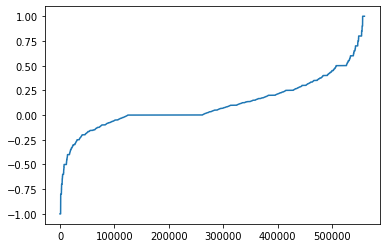

In [35]:
## distribution of scores in the yearly dataset. shows there are multiple neutral posts, with less negative tweets than positive overall
plt.plot(sorted(sentiment_sentences))

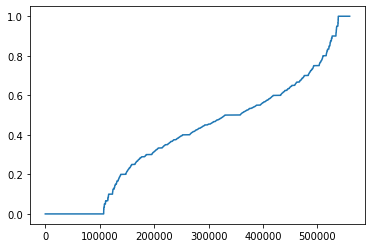

In [36]:
plt.plot(sorted(subjectivity_sentences))

### Plot sentiment frequency bar (across whole dataset)

Analyse all tweets from the year dataset and compute sentiment and subjectivity scores. Plot them to find dominant scores.

In [37]:
#getting sentiment
def getSentiment(pole):
    if pole<0:
        return 'Negative'
    elif pole==0:
        return 'Neutral'
    else:
        return 'Positive'

In [41]:
unique_tweets = extract_unique_tweets(data)

In [42]:
x=[]
for i in range(0,len(unique_tweets)):
    x.append([unique_tweets[i],sentiment_sentences[i],subjectivity_sentences[i],getSentiment(sentiment_sentences[i])])

setiment_frame= pd.DataFrame(x, columns=["tweets","Polarity","Subjectivity","Sentiment"])

#### Sentiment (polarity) graph

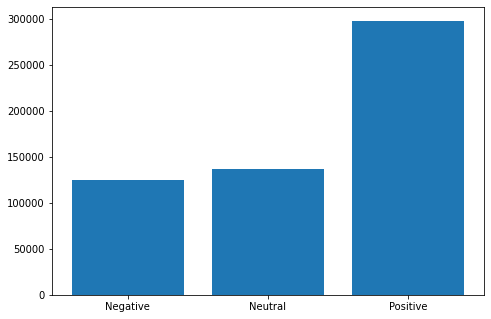

In [43]:
%matplotlib inline
neg=0
neu=0
pos=0
for i in setiment_frame['Sentiment']:
    if i == 'Negative':
        neg+=1
    elif i == 'Neutral':
        neu+=1
    else:
        pos+=1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiment = ['Negative', 'Neutral', 'Positive']
polarity = [neg,neu,pos]
ax.bar(sentiment,polarity)
plt.show()

#### Subjectivity graph

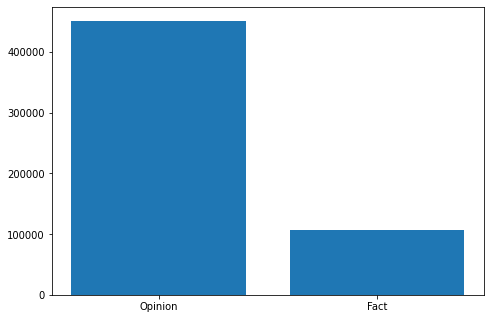

In [44]:
%matplotlib inline
fact=0
opi=0

for i in setiment_frame['Subjectivity']:
    if i > 0:
        opi+=1
    else:
        fact+=1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
subs = ['Opinion', 'Fact']
sub_value = [opi,fact]
ax.bar(subs,sub_value)
plt.show()

## Sentiment analysis - country

Plotting the map uses memory resources heavily (the "data" data frame contains many points, which might crash the notebook and restart the kernel)

In [ ]:
# pick a dataset for the sentiment analysis at country level
dataset_used = data#data_lockdown_1 # data

In [ ]:
# search term - example of a keyword of interest
search_keyword = "health"

# dates - example of dates to search for in the dataset
search_dates = {"start_date":"2020-12-10", "end_date":"2020-12-22"}
local_lockdown_dates = [str(date) for date in get_week_dates(search_dates)]

In [ ]:
# update dataset
dataset_used = dataset_used[
#     dataset_used["text"].str.contains(search_keyword) &
    dataset_used["date"].isin(local_lockdown_dates)
].sort_values(by=['date']).reset_index(drop=True)

In [52]:
print("number UK tweets:",len(dataset_used[dataset_used["country"] == "United Kingdom"]))
print("number non-tagged tweets:", len(dataset_used[dataset_used["country"] != "United Kingdom"]))

number UK tweets: 9197
number non-tagged tweets: 1


/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
## number unique coordinate areas
len(dataset_used["location_coordinates"].unique())

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1718

All coordinates are shaped as a rectangle. The "location_coordinates" column contains the coordinates of this area's corners. Find the latitude and longitude by computing the mean of these corners (as the location cannot be as precise as a point).

In [ ]:
## subset where the tweets are geotagged
subset_with_location = dataset_used[dataset_used["country"] == "United Kingdom"].reset_index(drop=True)

subset_with_location = subset_with_location.drop(
    columns=["time", "filename"]
)

In [ ]:
def extract_lat_lon(string):
    chars_to_remove = [",", "[", "]"]
    coords = [
        float("".join([c for c in word if c not in chars_to_remove]))
        for word in string.split(" ")
    ]
    # keep only 7 floating points
    lon = round(np.mean([coords[0], coords[2], coords[4], coords[6]]), 7)
    lat = round(np.mean([coords[1], coords[3], coords[5], coords[7]]), 7)
    
    return lat, lon

In [ ]:
lat_list = []
lon_list = []

for coordinate in subset_with_location["location_coordinates"]:
    lat_c, lon_c = extract_lat_lon(coordinate)
    lat_list.append(lat_c)
    lon_list.append(lon_c)
    
subset_with_location["lat"] = lat_list
subset_with_location["lon"] = lon_list
subset_with_location = subset_with_location.drop(columns="location_coordinates")

### Sentiment of the posts - add column to the dataset

In [ ]:
sentiment_score = [
    TextBlob(tweet).sentiment.polarity
    for tweet in subset_with_location["text"]
]

# add new column
subset_with_location["sentiment_score"] = sentiment_score

### Plot map using Mapbox

The following cells plot tweet sentiments and the location of the tweet in the United Kingdom. This can be changed given a date.

In [ ]:
!pip install plotly

In [ ]:
from plotly import express as px
import pandas as pd
import plotly

In [ ]:
mapbox_token = 'pk.eyJ1IjoibXRlY3VzYW51IiwiYSI6ImNrbWppMng5ejByYTIyd2s1NTI0d2xsaHgifQ.tyIZb7ojGxXyYKE2UDyEwA'
px.set_mapbox_access_token(mapbox_token)

In [63]:
subset_with_location.head()

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text hashtags         country  \
0  had my 1 lesson back since lockdown abs i driv...       []  United Kingdom   
1  how amazing is peter a resident at our shelter...       []  United Kingdom   
2  days are always fun with this little man 😊❤️ e...       []  United Kingdom   
3  wales that’s what happens when you let immatur...       []  United Kingdom   
4  it’s actual too far how vile i’ve looked throu...       []  United Kingdom   

         location_name        date        lat       lon  sentiment_score  
0        Ryde, England  2020-12-10  50.726852 -1.163604         0.033333  
1  Warrington, England  2020-12-10  53.382608 -2.593300         0.233333  
2  Manchester, England  2020-12-10  53.456953 -2.233480         0.037500  
3   Wandsworth, London  2020-12-10  51.451656 -0.193719        -0.093750  
4   Muirhead, Scotland  2020-12-10  55.550544 -4.636673        -0.077778

The following graph plots sentiments and their intensities:
- <b>red:</b> positive sentiment
- <b>white:</b> neutral sentiment
- <b>blue:</b> negative sentiment

In [64]:
fig = px.scatter_mapbox(
    subset_with_location,
    lat="lat",
    lon="lon",
#     size_max=20,
    height=600,
    zoom=4,
    color="sentiment_score",
    color_continuous_scale=px.colors.cyclical.IceFire,
    animation_frame="date",
    range_color=[-1, 1]
)

fig.show()

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Sentiment analysis - Emotion analysis

https://colab.research.google.com/drive/1sCAcIGk2q9dL8dpFYddnsUin2MlhjaRw?usp=sharing#scrollTo=ivUkOaBPEQYr
https://pypi.org/project/text2emotion/

Compatible with 5 different emotion categories as Happy, Angry, Sad, Surprise and Fear.

<b>Text2Emotion works on RAW text</b>

In [ ]:
!pip install text2emotion

In [ ]:
import text2emotion as te

In [29]:
## Test on some emojis - RAW (it does preprocessing)

In [30]:
unique_tweets = extract_unique_tweets(data)

In [31]:
text = unique_tweets[10]

In [32]:
text

'check out tittytittybangbang’s page for an updated catalogue with digital versions of our live lockdown streams just in time to remind you about this evening stream - it’s number 11 11th week of…'

In [33]:
te.get_emotion(text)

{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}

### Test on 10 posts

In [149]:
emotions_list = []

for index in tqdm(range(10)):
    t = unique_tweets[index]
    tweet_emotions = te.get_emotion(t)
    emotions_list.append(tweet_emotions)

100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


In [150]:
happy_score = np.mean([e['Happy'] for e in emotions_list])
angry_score = np.mean([e['Angry'] for e in emotions_list])
surprise_score = np.mean([e['Surprise'] for e in emotions_list])
sad_score = np.mean([e['Sad'] for e in emotions_list])
fear_score = np.mean([e['Fear'] for e in emotions_list])

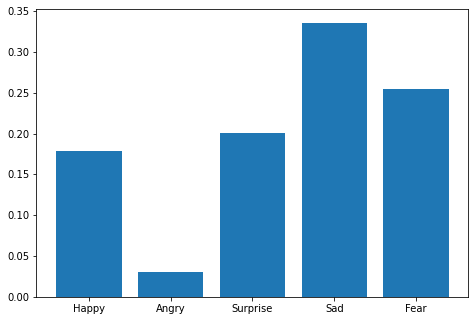

In [151]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
emotion = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']
average_emotion_score = [happy_score, angry_score, surprise_score, sad_score, fear_score]
ax.bar(emotion,average_emotion_score)
plt.show()

## Data Frame tagged with emotion scores - (DO NOT RUN)

### The tagged dataset can be downloaded from the drive

Processing time: 26 hours.

In [49]:
len(data["text"])

573272

In [36]:
## Use data["text"] to create a dataframe containing text and emotion scores
emotions_df = pd.DataFrame(data["text"], columns=["text"])

In [37]:
emotions_df.head()

text
0  we have decided we are going to write off the ...
1  supposed to be goin venice in 2 week & still f...
2  because milan and venice airports are open eve...
3  *sound on*for francesca who is finding life ve...
4                 venice trip looks screwed lockdown

In [38]:
def calculate_and_store_emotion_scores(tweet):
    tweet_emotions = te.get_emotion(tweet)
    # return emotion scores and the index of the tweet in
    # the original dataframe
    return tweet_emotions

In [40]:
emotion_results = []

In [41]:
for index in tqdm(range(len(emotions_df["text"]))):
    emotion_results.append(calculate_and_store_emotion_scores(emotions_df["text"][index]))

100%|██████████| 573272/573272 [26:42:03<00:00,  5.96it/s]     


In [42]:
len(emotion_results)

573272

In [43]:
# store emotions
happy_scores = [p["Happy"] for p in emotion_results]
angry_scores = [p["Angry"] for p in emotion_results]
surprise_scores = [p["Surprise"] for p in emotion_results]
sad_scores = [p["Sad"] for p in emotion_results]
fear_scores = [p["Fear"] for p in emotion_results]

In [45]:
emotions_df["happy_score"] = happy_scores
emotions_df["angry_score"] = angry_scores
emotions_df["surprise_score"] = surprise_scores
emotions_df["sad_score"] = sad_scores
emotions_df["fear_score"] = fear_scores

In [46]:
emotions_df.head()

text  happy_score  \
0  we have decided we are going to write off the ...          0.0   
1  supposed to be goin venice in 2 week & still f...          0.0   
2  because milan and venice airports are open eve...          0.0   
3  *sound on*for francesca who is finding life ve...          0.0   
4                 venice trip looks screwed lockdown          0.0   

   angry_score  surprise_score  sad_score  fear_score  
0         0.00            0.00       0.00         1.0  
1         0.25            0.00       0.25         0.5  
2         0.00            0.25       0.25         0.5  
3         0.00            0.00       0.00         1.0  
4         0.00            0.00       0.00         0.0

In [47]:
file_name = "all_year"

In [48]:
emotions_df.to_csv(f'data/emotions_tagged_{file_name}.csv', index=False)

# Load emotion scores from file (START HERE)

In [47]:
file_name = "all_year"

In [48]:
with open(f'data/emotions_tagged_{file_name}.csv') as csvfile:
    f = csv.DictReader(csvfile)
    emotions_df = pd.DataFrame(f)

In [49]:
unique_tweets_in_data = data["text"].unique()
unique_tweets_in_emotions = emotions_df["text"].unique()

In [50]:
len(unique_tweets_in_data)

559178

#### Some posts have been split by the text2emotion library (when containig special characters)

Remove samples where posts are split in two from the emotions dataframe and make sure both dataframes have the same length

In [51]:
# lists of indices to be removed
remove_from_data = []
remove_from_emotions = []

In [52]:
index_data = 0
index_emotions = 0

while index_data < len(data):
    
    if data["text"][index_data] != emotions_df["text"][index_emotions]:
        remove_from_data.append(index_data)
        # remove next two posts
        remove_from_emotions.append(index_emotions)
        remove_from_emotions.append(index_emotions + 1)
        # skip to the next post
        index_emotions +=1
    
    index_data += 1
    index_emotions += 1

In [53]:
# drop rows containing split texts
data = data.drop(remove_from_data)
emotions_df = emotions_df.drop(remove_from_emotions)

In [54]:
## compare dataframe lengths
unique_tweets_in_data = data["text"].unique()
unique_tweets_in_emotions = emotions_df["text"].unique()

In [55]:
print(len(emotions_df))
print(len(data))

573265
573265


In [56]:
# reset indeces
data = data.reset_index(drop=True)
emotions_df = emotions_df.reset_index(drop=True)

## Analyse emotions given a time frame

In [57]:
# merge scores into the original dataframe
data_with_emotion = pd.merge(data, emotions_df, on='text')
data_with_emotion = data_with_emotion.drop(columns=["filename"])

In [58]:
data_with_emotion.head()

text           hashtags  \
0  we have decided we are going to write off the ...                 []   
1  supposed to be goin venice in 2 week & still f...                 []   
2  because milan and venice airports are open eve...                 []   
3  *sound on*for francesca who is finding life ve...  ['relax', 'rest']   
4                 venice trip looks screwed lockdown       ['lockdown']   

          country             location_name  \
0  United Kingdom        Strood, South East   
1  United Kingdom           Oldham, England   
2  United Kingdom  Scotland, United Kingdom   
3  United Kingdom      Shaftesbury, England   
4  United Kingdom           Marple, England   

                                location_coordinates        date      time  \
0  [[[0.4496776, 51.3828931], [0.499886, 51.38289...  2020-03-08  10:02:05   
1  [[[-2.185708, 53.492866], [-2.048031, 53.49286...  2020-03-08  10:13:56   
2  [[[-7.66085699743185, 54.6336309570711], [-0.7...  2020-03-08  10:14:27   
3  [[[-2.2152049, 50.997428], [-2.1774652, 50.997...  2020-03-08  10:25:06   
4  [[[-2.090605, 53.380423], [-2.0507618, 53.3804...  2020-03-08  10:42:41   

  happy_score angry_score surprise_score sad_score fear_score  
0         0.0         0.0            0.0       0.0        1.0  
1         0.0        0.25            0.0      0.25        0.5  
2         0.0         0.0           0.25      0.25        0.5  
3         0.0         0.0            0.0       0.0        1.0  
4         0.0         0.0            0.0       0.0        0.0

In [59]:
# Convert emotion score columns to numeric type (float)
col_names = ["happy_score", "angry_score", "surprise_score", "sad_score", "fear_score"]
data_with_emotion[col_names] = data_with_emotion[col_names].apply(pd.to_numeric)

In [60]:
# all unique days in our dataset
sorted_unique_dates = sorted(data_with_emotion["date"].unique())
print(len(sorted_unique_dates))

385


In [61]:
def calculate_avg_emotion_score_per_day(column_name, date_range):    
    return [
        np.mean(
            data_with_emotion[
                data_with_emotion["date"] == date_val
            ][column_name]
        )
        for date_val in date_range
    ]

# set date range
# date_range = sorted_unique_dates[:20]
# date_range = [str(d) for d in get_week_dates(lockdown_3)]
date_range = [d.strftime("%Y-%m-%d") for d in get_week_dates(lockdown_3)]


avg_score_happy = calculate_avg_emotion_score_per_day("happy_score", date_range)
avg_score_angry = calculate_avg_emotion_score_per_day("angry_score", date_range)
avg_score_surprise = calculate_avg_emotion_score_per_day("surprise_score", date_range)
avg_score_sad = calculate_avg_emotion_score_per_day("sad_score", date_range)
avg_score_fear = calculate_avg_emotion_score_per_day("fear_score", date_range)

<IPython.core.display.Javascript object>


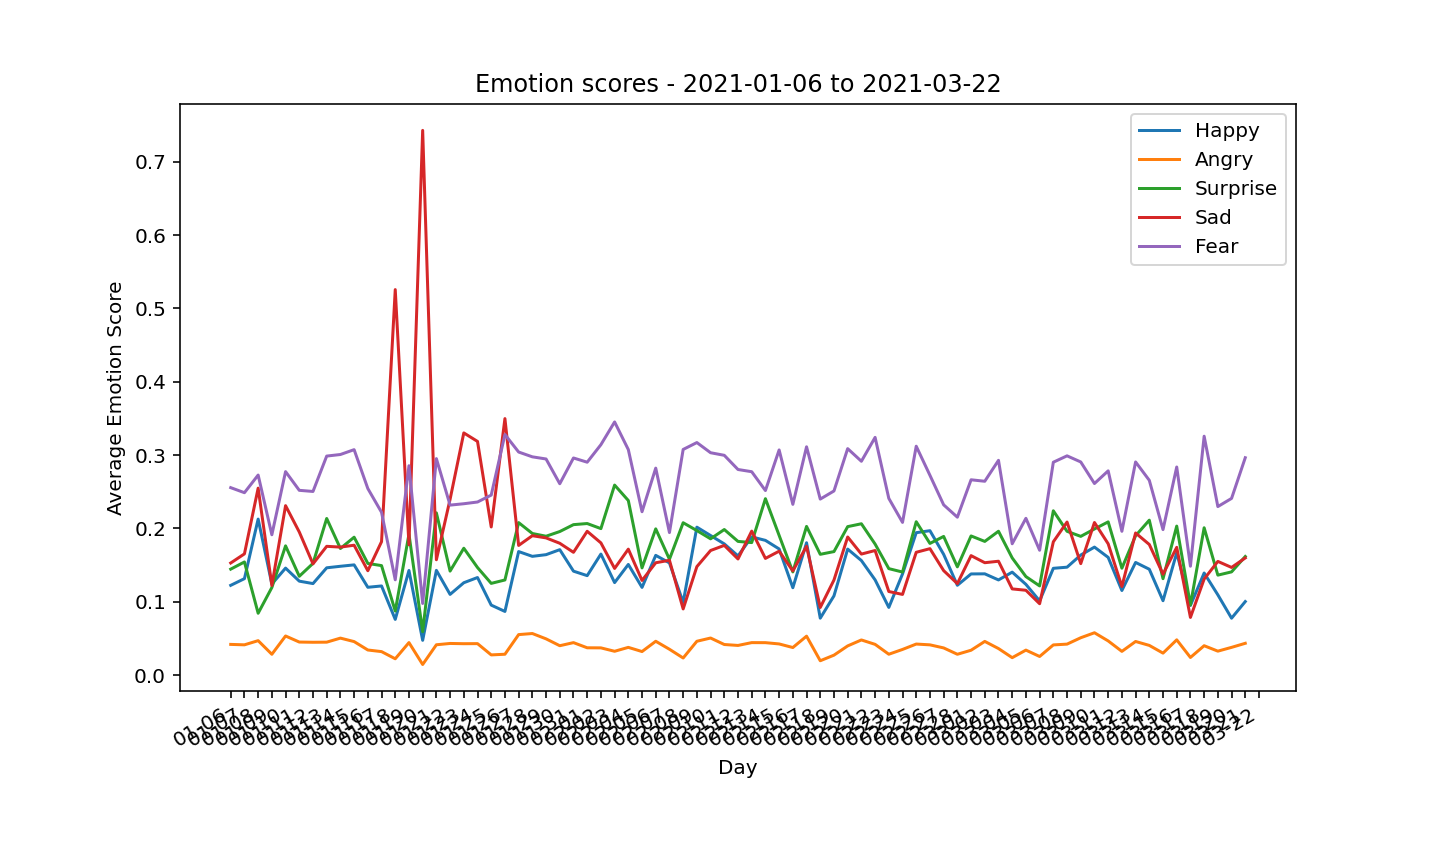

In [87]:
%matplotlib notebook

# Unique dates
x = [d[5:] for d in date_range]

# set figure size
plt.figure(figsize=(10,6))

plt.plot(x, avg_score_happy, label = "Happy")
plt.plot(x, avg_score_angry, label = "Angry")
plt.plot(x, avg_score_surprise, label = "Surprise")
plt.plot(x, avg_score_sad, label = "Sad")
plt.plot(x, avg_score_fear, label = "Fear")

plt.xlabel('Day')
plt.ylabel('Average Emotion Score')

# Set a title of the current axes.
plt.title(f'Emotion scores - {date_range[0]} to {date_range[-1]}')

# show a legend on the plot
plt.legend()
# x axis
plt.gcf().autofmt_xdate()
# Display a figure.
plt.show()

### Plot emotion dominance

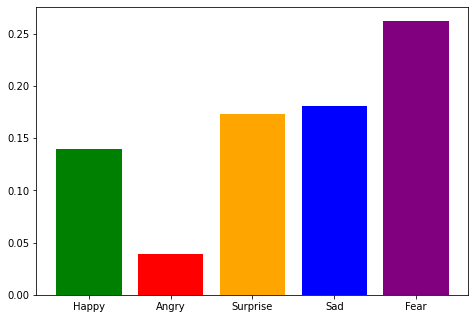

In [64]:
happy=np.mean(avg_score_happy[:75])
angry=np.mean(avg_score_angry[:75])
surprise=np.mean( avg_score_surprise[:75])
sad=np.mean(avg_score_sad[:75])
fear= np.mean(avg_score_fear[:75])

%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
emotion = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']
average_emotion_score = [happy,angry,surprise, sad, fear]
ax.bar(emotion,average_emotion_score, color=['green', 'red', 'orange', 'blue', 'purple'])
plt.show()

# Step 8: Hashtag analysis

Analyse hashtag statistics

In [65]:
from collections import Counter

In [66]:
def extract_hashtags(dataset):
    
    all_hashtags = []

    for h in dataset["hashtags"]:
        # h is a string
        converted_string = h.replace('\'', '"')
        x = json.loads(converted_string)    
        if len(x):
            all_hashtags.extend(x)
            
    # lowercase all hashtags
    lowered = [h.lower() for h in all_hashtags]
    
    return lowered

#### Create counters for all periods

In [67]:
counter_hashtags_year = Counter(extract_hashtags(data)).most_common()
counter_hashtags_lockdown_1 = Counter(extract_hashtags(data_lockdown_1)).most_common()
counter_hashtags_lockdown_2 = Counter(extract_hashtags(data_lockdown_2)).most_common()
counter_hashtags_lockdown_3 = Counter(extract_hashtags(data_lockdown_3)).most_common()

#### Compare top 20 hashtags

In [68]:
print(counter_hashtags_year[:20])

[('lockdown', 72946), ('covid19', 11670), ('coronavirus', 7665), ('staysafe', 4063), ('stayhome', 3682), ('london', 3606), ('covid_19', 2914), ('covid19uk', 2525), ('covid', 2449), ('lockdownuk', 2238), ('stayathome', 2141), ('stayhomesavelives', 2038), ('socialdistancing', 1799), ('lockdown2020', 1670), ('covidー19', 1633), ('uk', 1600), ('lockdown2', 1535), ('suicideawareness', 1474), ('coronavirusuk', 1401), ('mentalhealth', 1375)]


In [69]:
print(counter_hashtags_lockdown_1[:20])

[('lockdown', 29322), ('covid19', 4461), ('coronavirus', 3632), ('stayhome', 2433), ('staysafe', 1944), ('stayhomesavelives', 1613), ('covid_19', 1358), ('stayathome', 1243), ('london', 1004), ('lockdownuk', 821), ('socialdistancing', 777), ('isolation', 738), ('lockdown2020', 724), ('covid', 719), ('covidー19', 637), ('quarantine', 623), ('nhs', 603), ('covid19uk', 583), ('corona', 495), ('scotland', 491)]


In [70]:
print(counter_hashtags_lockdown_2[:20])

[('lockdown', 3356), ('lockdown2', 652), ('covid19', 375), ('london', 248), ('lockdown2uk', 236), ('coronavirus', 197), ('staysafe', 175), ('covid', 165), ('lockdownuk', 146), ('mentalhealth', 146), ('christmas', 136), ('covid_19', 129), ('lockdown2020', 127), ('shoplocal', 125), ('uk', 110), ('covid19uk', 105), ('autumn', 97), ('fitness', 92), ('art', 88), ('wellbeing', 88)]


In [71]:
print(counter_hashtags_lockdown_3[:20])

[('lockdown', 9912), ('covid19', 1414), ('lockdown2021', 894), ('lockdown3', 597), ('london', 575), ('covid', 572), ('staysafe', 461), ('coronavirus', 440), ('lockdownlife', 364), ('stayhome', 345), ('covid19uk', 344), ('londonprotest', 339), ('covidiots', 334), ('mentalhealth', 311), ('lockdownuk', 268), ('uk', 254), ('homeschooling', 224), ('endthelockdown', 213), ('walk', 210), ('wellbeing', 200)]


### Ratio of hastags to number of posts per lockdown

In [72]:
### For lockdown 3
print(
    [(hashtag, count / len(data_lockdown_3))
    for hashtag, count in counter_hashtags_lockdown_3[:20]]
)

[('lockdown', 0.08761524250647479), ('covid19', 0.012498784594850218), ('lockdown2021', 0.007902343301128779), ('lockdown3', 0.00527706817759942), ('london', 0.005082603353634282), ('covid', 0.005056085423093582), ('staysafe', 0.004074921993087659), ('coronavirus', 0.003889296479302755), ('lockdownlife', 0.003217508905605007), ('stayhome', 0.0030495620121805695), ('covid19uk', 0.003040722702000336), ('londonprotest', 0.002996526151099168), ('covidiots', 0.0029523296001980007), ('mentalhealth', 0.002749025466052629), ('lockdownuk', 0.0023689351283025873), ('uk', 0.002245184785779318), ('homeschooling', 0.0019800054803723118), ('endthelockdown', 0.0018827730683897428), ('walk', 0.0018562551378490423), ('wellbeing', 0.0017678620360467069)]


In [73]:
### For lockdown 2
print(
    [(hashtag, count / len(data_lockdown_2))
    for hashtag, count in counter_hashtags_lockdown_2[:20]]
)

[('lockdown', 0.0935235759670048), ('lockdown2', 0.01816965778619998), ('covid19', 0.01045033998439416), ('london', 0.0069111581763460035), ('lockdown2uk', 0.006576747296845391), ('coronavirus', 0.005489911938468399), ('staysafe', 0.004876825326050607), ('covid', 0.00459814959313343), ('lockdownuk', 0.004068665700590793), ('mentalhealth', 0.004068665700590793), ('christmas', 0.003789989967673615), ('covid_19', 0.003594916954631591), ('lockdown2020', 0.003539181808048155), ('shoplocal', 0.0034834466614647197), ('uk', 0.003065433062088953), ('covid19uk', 0.0029260951956303644), ('autumn', 0.0027031546092966224), ('fitness', 0.0025638167428380337), ('art', 0.0024523464496711625), ('wellbeing', 0.0024523464496711625)]


### Rate of tweets per day containing a given hashtag

In [74]:
### For lockdown 3
print(
    [(hashtag, count / len(data_lockdown_3["date"].unique()))
    for hashtag, count in counter_hashtags_lockdown_3[:20]]
)

[('lockdown', 132.16), ('covid19', 18.85333333333333), ('lockdown2021', 11.92), ('lockdown3', 7.96), ('london', 7.666666666666667), ('covid', 7.626666666666667), ('staysafe', 6.1466666666666665), ('coronavirus', 5.866666666666666), ('lockdownlife', 4.8533333333333335), ('stayhome', 4.6), ('covid19uk', 4.586666666666667), ('londonprotest', 4.52), ('covidiots', 4.453333333333333), ('mentalhealth', 4.1466666666666665), ('lockdownuk', 3.5733333333333333), ('uk', 3.3866666666666667), ('homeschooling', 2.986666666666667), ('endthelockdown', 2.84), ('walk', 2.8), ('wellbeing', 2.6666666666666665)]


In [75]:
### For lockdown 1
print(
    [(hashtag, count / len(data_lockdown_1["date"].unique()))
    for hashtag, count in counter_hashtags_lockdown_1[:20]]
)

[('lockdown', 637.4347826086956), ('covid19', 96.97826086956522), ('coronavirus', 78.95652173913044), ('stayhome', 52.891304347826086), ('staysafe', 42.26086956521739), ('stayhomesavelives', 35.06521739130435), ('covid_19', 29.52173913043478), ('stayathome', 27.02173913043478), ('london', 21.82608695652174), ('lockdownuk', 17.847826086956523), ('socialdistancing', 16.891304347826086), ('isolation', 16.043478260869566), ('lockdown2020', 15.73913043478261), ('covid', 15.630434782608695), ('covidー19', 13.847826086956522), ('quarantine', 13.543478260869565), ('nhs', 13.108695652173912), ('covid19uk', 12.673913043478262), ('corona', 10.76086956521739), ('scotland', 10.673913043478262)]


In [76]:
%matplotlib inline
# Using the matplotlib inline to avoid unnecessary scolling caused due to %matplotlib notebook
import matplotlib.pyplot as plt
def plot_graph(plot_data,name):
    x=[]
    y=[]
    for i,j in plot_data:
        x.append(i)
        y.append(j)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_axes([0,0,1,1])
    hashtags = x
    count_of_tags = y
    y_pos = np.arange(len(hashtags))
    ax.barh(y_pos, count_of_tags, align='center')
    plt.yticks(y_pos, hashtags)
    plt.xlabel('Frequency of hashtags',)
    plt.ylabel('Hashtags')
    plt.title(f'Popular hashtags of {name}',fontweight='bold')
    plt.show()
    
    

/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/miruna/Desktop/TM/comp61332---cw2/venv/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


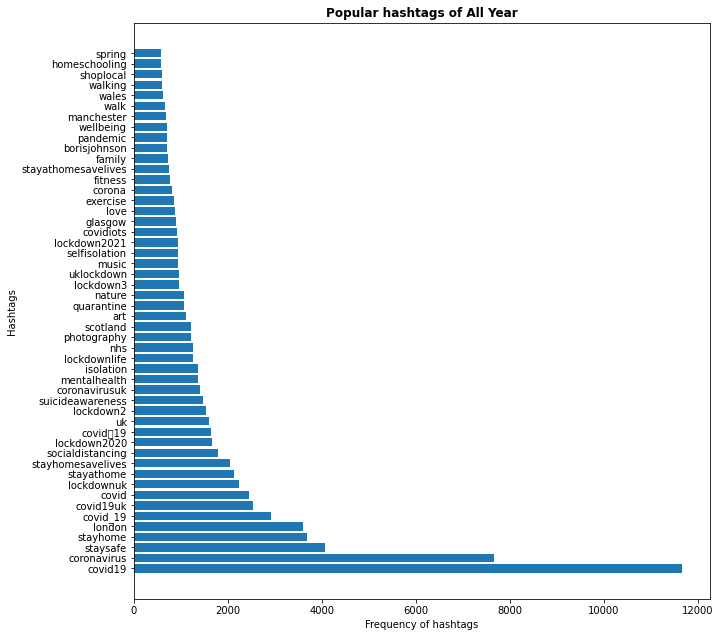

In [77]:
plot_graph(counter_hashtags_year[1:51],"All Year")

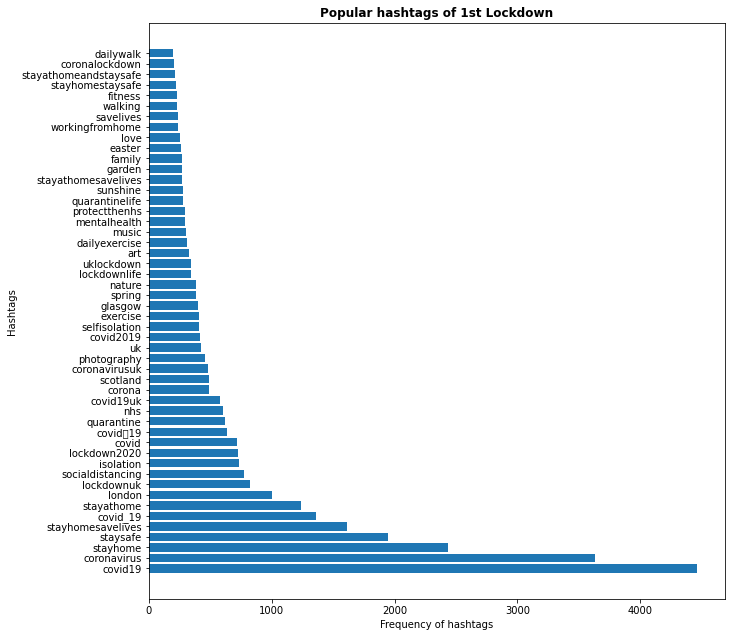

In [78]:
plot_graph(counter_hashtags_lockdown_1[1:51],"1st Lockdown")

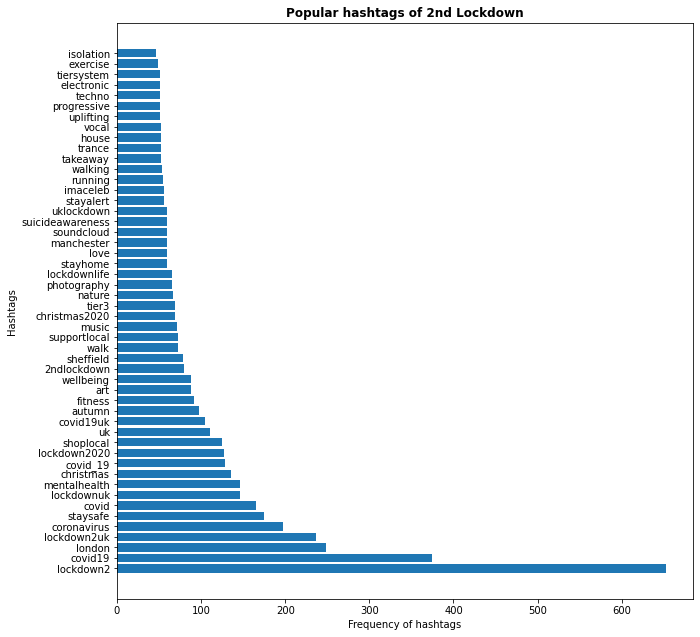

In [79]:
plot_graph(counter_hashtags_lockdown_2[1:51],"2nd Lockdown")

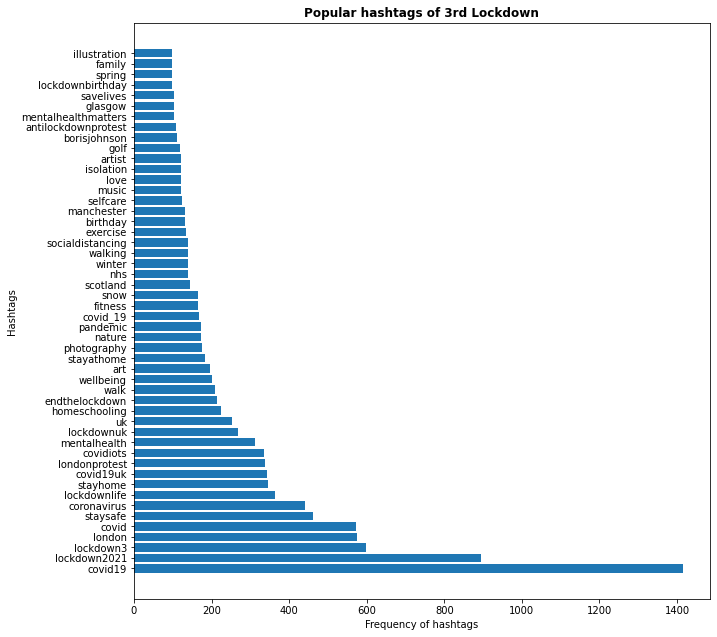

In [80]:
plot_graph(counter_hashtags_lockdown_3[1:51],"3rd Lockdown")

In [81]:
#to get the common hashtags between the three lockdowns
A=[]
B=[]
C=[]
for i,_ in counter_hashtags_lockdown_1[1:51]:
        A.append(i)
for i,_ in counter_hashtags_lockdown_2[1:51]:
        B.append(i)
for i,_ in counter_hashtags_lockdown_3[1:51]:
        C.append(i)
commons=list(set(list(set(B).intersection(C))).intersection(A)) 

In [82]:
# the common hashtags between the three lockdowns 
commons

['covid_19',
 'lockdownuk',
 'covid19',
 'nature',
 'isolation',
 'lockdownlife',
 'covid',
 'fitness',
 'london',
 'uk',
 'exercise',
 'art',
 'photography',
 'love',
 'mentalhealth',
 'music',
 'coronavirus',
 'covid19uk',
 'walking',
 'staysafe',
 'stayhome']

In [83]:
# to print comparison of top hashtags between the three lockdowns
def groupgraph(a,b,c,name,yname='Frequency',xname='Hashtags'):
    dictA= {i[0]: i[1] for i in a}
    dictB= {i[0]: i[1] for i in b}
    dictC= {i[0]: i[1] for i in c}

    lockdown1=[]
    lockdown2=[]
    lockdown3=[]

    for i in commons:
        lockdown1.append(dictA[i])
        lockdown2.append(dictB[i])
        lockdown3.append(dictC[i])
    

    #plotting graph
    fig, ax = plt.subplots(figsize=(25,15))
    bar_width = 0.25
    opacity = 0.8

    # Setting position of bars
    r = np.arange(len(commons))

    g1 = plt.bar(r + 0.00, lockdown1, width=bar_width,alpha=opacity,color='r',label='Lockdown 1')

    g2 = plt.bar(r + 0.25, lockdown2, width=bar_width, alpha=opacity,color='g',label='Lockdown 2')

    g3 = plt.bar(r + 0.50, lockdown3, width=bar_width,alpha=opacity,color='b',label='Lockdown 3')



    plt.xlabel(xname, fontsize=20)
    plt.ylabel(yname, fontsize=20)
    plt.title(f'Hashtags comparison between 3 Lockdowns: {name}',fontweight='bold', fontsize=20)
    plt.xticks(r + bar_width, commons)

    plt.legend()

    plt.tight_layout()
    plt.show()

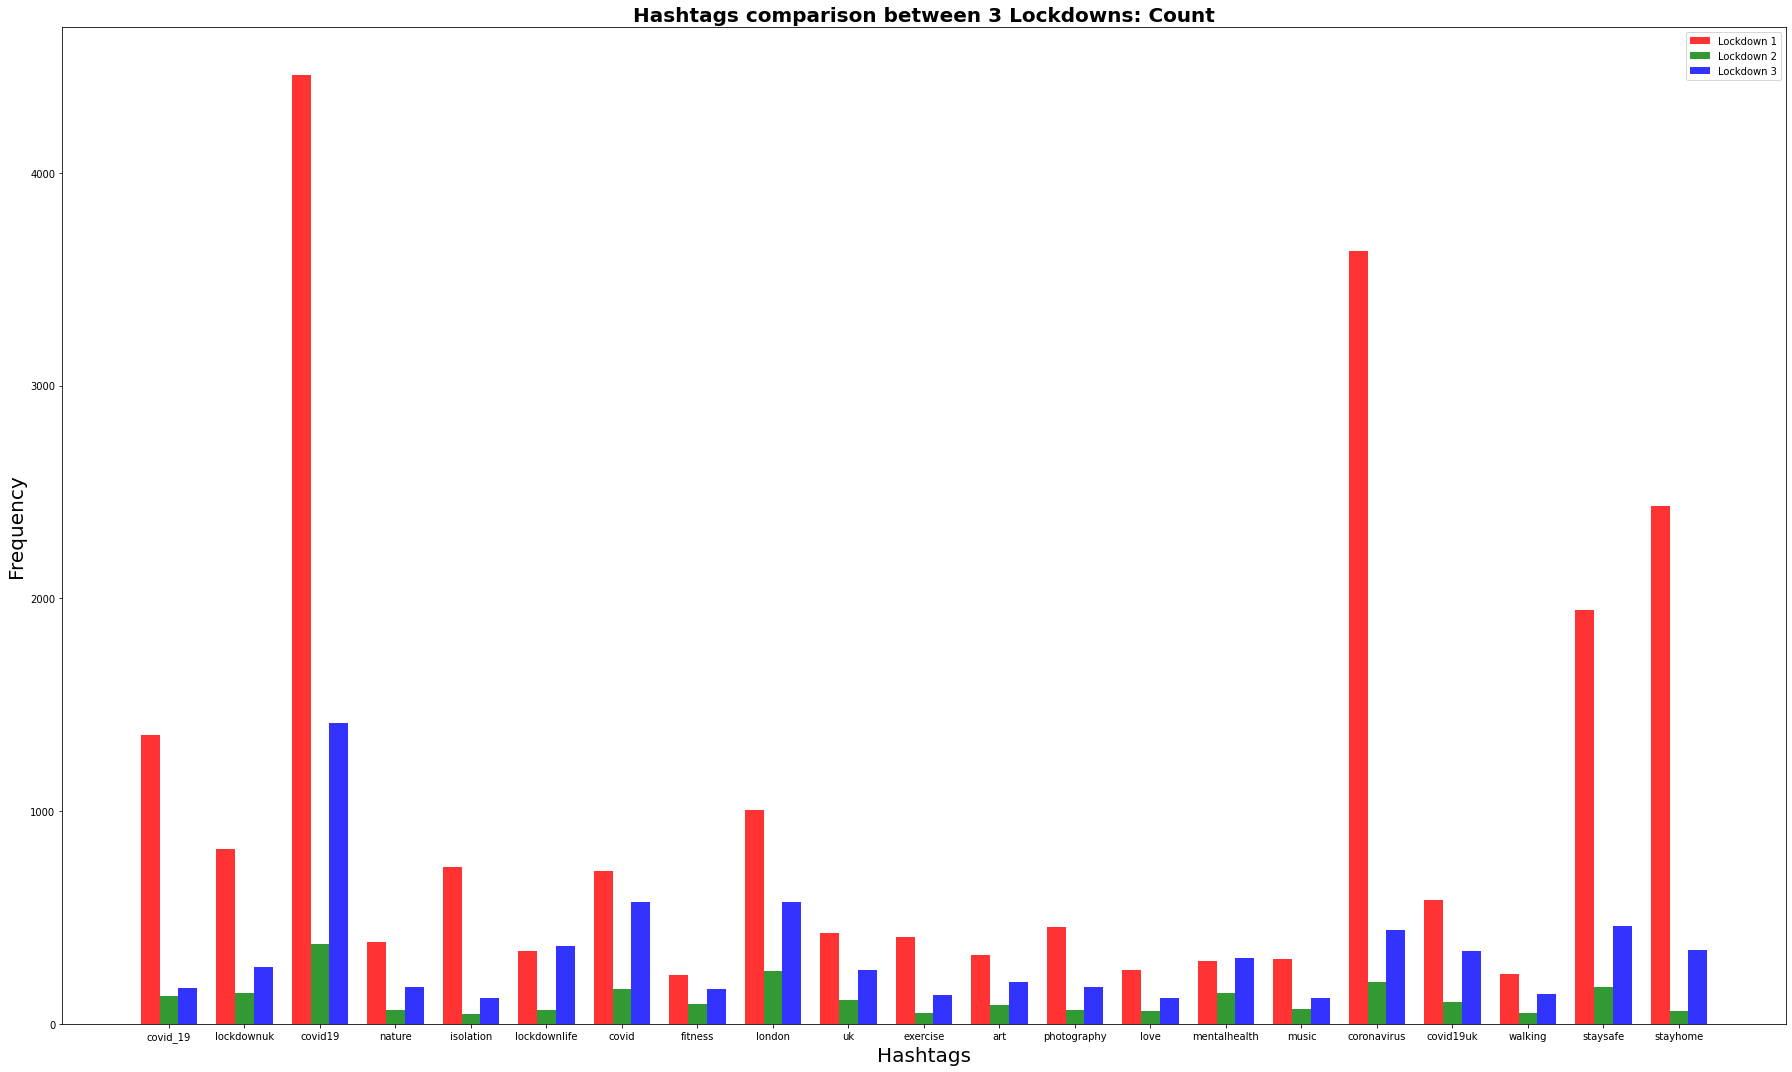

In [84]:
groupgraph(counter_hashtags_lockdown_1[1:51],counter_hashtags_lockdown_2[1:51],counter_hashtags_lockdown_3[1:51],"Count")

In [85]:
# Getting the ratio of each hashtags in all the tweets per lockdown
ratio1= [(hashtag, (count / len(data_lockdown_1))*100) for hashtag, count in counter_hashtags_lockdown_1[1:51]]
ratio2=[(hashtag, (count / len(data_lockdown_2))*100)for hashtag, count in counter_hashtags_lockdown_2[1:51]]
ratio3= [(hashtag, (count / len(data_lockdown_3))*100) for hashtag, count in counter_hashtags_lockdown_3[1:51]]

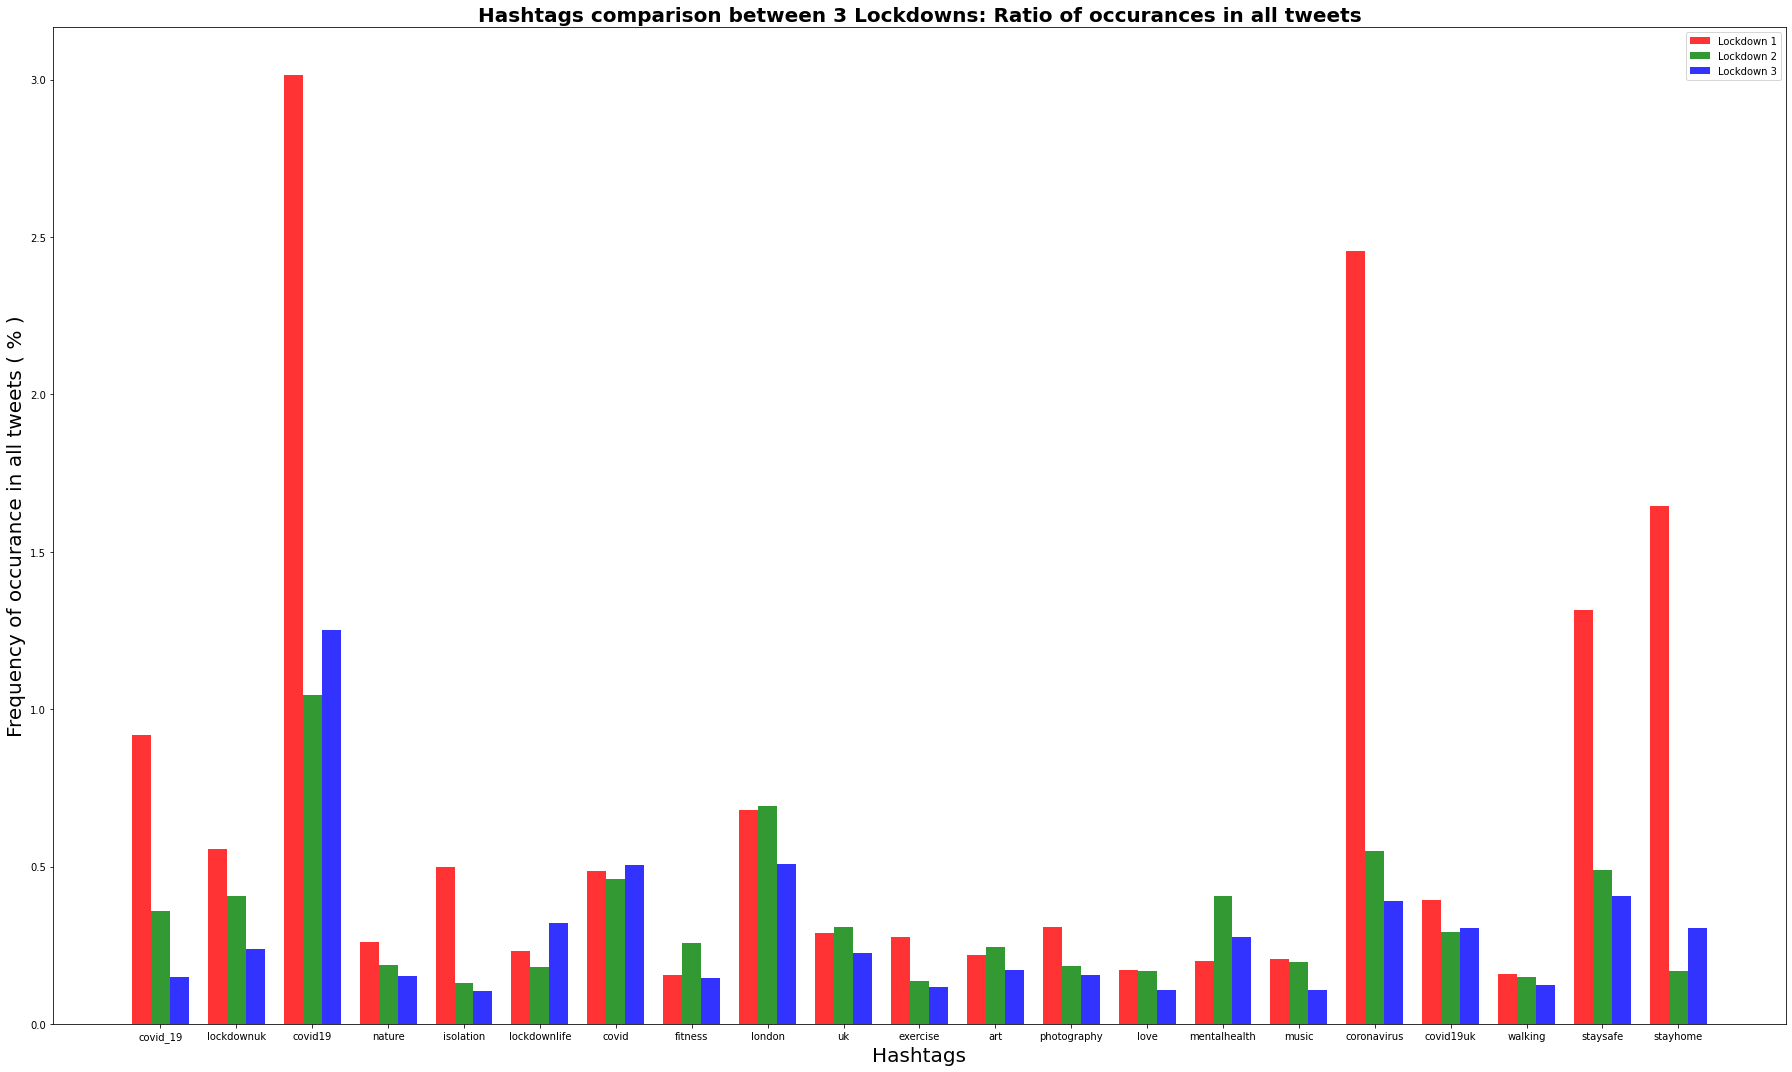

In [86]:
groupgraph(ratio1,ratio2,ratio3,"Ratio of occurances in all tweets",yname='Frequency of occurance in all tweets ( % )')

# Step 9: Named Entity Recognition

This implementation is based on [spaCy's model](https://spacy.io/models/en#en_core_web_trf) using contextualised embeddings.

Spacy was used as opposed to Twitter NER or Stanford's NER models due to it's fast processing times and plethora of tags. The following cells show the most common named entities and their text

## Spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [89]:
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')

In [90]:
def entity_recognition(dataset_used):
    discovered_entities = dict()

    # set the dataset - to be used
    # dataset_used = data_lockdown_2#[:100]

    for index in tqdm(range(len(dataset_used["text"]))):

        tweet_text = dataset_used["text"][index]
        doc = nlp(tweet_text)
        entities = doc.ents

        if len(entities):
            tweet_entities = []
            for ne in entities:
                entity_type = ne.label_
                entity_text = tweet_text[ne.start_char:ne.end_char]
                tweet_entities.append([entity_type, entity_text])

            discovered_entities[index] = tweet_entities

100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


In [ ]:
# discovered_entities
announcement_3_entities = entity_recognition(data_lockdown_announcement_3)
announcement_2_entities = entity_recognition(data_lockdown_announcement_2)
announcement_1_entities = entity_recognition(data_lockdown_announcement_1)

### Most common entity type

In [91]:
from collections import Counter

In [92]:
def create_entity_counter(index, dictionary):
    return Counter(
        [
            tupl[index]
            for index_tweet in dictionary.keys()
            for tupl in dictionary[index_tweet]
        ]
    ).most_common()

entity_type_counter = create_entity_counter(0, discovered_entities)
entity_text_counter = create_entity_counter(1, discovered_entities)

entity_type_counter_1 = create_entity_counter(0, announcement_1_entities)
entity_text_counter_1 = create_entity_counter(1, announcement_1_entities)

entity_type_counter_2 = create_entity_counter(0, announcement_2_entities)
entity_text_counter_2 = create_entity_counter(1, announcement_2_entities)

entity_type_counter_3 = create_entity_counter(0, announcement_3_entities)
entity_text_counter_3 = create_entity_counter(1, announcement_3_entities)

In [ ]:
#to get the common hashtags between the three lockdowns
A=[]
B=[]
C=[]
for i,_ in entity_type_counter_1:
        A.append(i)
for i,_ in entity_type_counter_2:
        B.append(i)
for i,_ in entity_type_counter_3:
        C.append(i)
commons=list(set(list(set(B).intersection(C))).intersection(A)) 

In [ ]:
# Getting the ratio of each hashtags in all the tweets per lockdown
ratio1= [(entity_type[0], (entity_type[1] / len(announcement_1_entities))*100) for entity_type in entity_type_counter_1]
ratio2= [(entity_type[0], (entity_type[1] / len(announcement_2_entities))*100) for entity_type in entity_type_counter_2]
ratio3= [(entity_type[0], (entity_type[1] / len(announcement_3_entities))*100) for entity_type in entity_type_counter_3]
groupgraph(ratio1,ratio2,ratio3,"% out of all entities",yname='Frequency of occurance out of all entities ( % )')

## NLTK StanfordNLTKTagger

In [ ]:
# from nltk.tag.stanford import StanfordNERTagger
# from nltk.tokenize import word_tokenize

# nltk.download('punkt')

In [ ]:
# st = StanfordNERTagger('english.muc.7class.distsim.crf.ser.gz', 'stanford-ner.jar', encoding='utf-8')

In [ ]:
# java_path = "C:/Program Files/Java/jre1.8.0_291/bin/java.exe"
# os.environ['JAVAHOME'] = java_path

In [ ]:
# for tweet_text in unique_tweets[:10]:
#     tokenized_text = word_tokenize(tweet_text)
#     print(tweet_text)
#     classified_text = st.tag(tokenized_text)
#     for elem in classified_text:
#         if elem[1] != 'O':
#             print('\tNE found: ', elem)

## TwitterNER

In [ ]:
# !pip install wget

In [ ]:
# ## Install TwitterNER
# import zipfile
# import wget

# !git clone --depth=1 https://github.com/napsternxg/TwitterNER.git
# %cd TwitterNER
# %pip install -r requirements.txt

# url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
# path_to_zip_file = "data/glove_twitter.zip"
# wget.download(url, path_to_zip_file)


# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall("data")
    
# %cd ..

In [ ]:
# %ls

In [ ]:
# %cd TwitterNER
# %cd NoisyNLP


# from run_ner import TwitterNER
# from twokenize import tokenizeRawTweetText

# ner = TwitterNER()
# %cd ../..

In [ ]:
# for tweet_text in unique_tweets[:50]:
#     tokenized_text = tokenizeRawTweetText(tweet_text)
#     classified_text = ner.get_entities(tokenized_text)
#     if classified_text:
#         print(tweet_text)
#         for elem in classified_text:
#             print(f'\tNE found: {elem} entity: {" ".join(tokenized_text[elem[0]:elem[1]])}')
#         print("=====================================================================")

# Step 10: Named Entity Linking

This implementation is based on [spaCy Entity Linker](https://github.com/egerber/spacy-entity-linker).

In [ ]:
!pip install spacy-entity-linker
!python -m spacyEntityLinker "download_knowledge_base"

In [96]:
from spacyEntityLinker import EntityLinker
from spacy.language import Language

@Language.factory(
   "entityLinker"
)
def create_linker(nlp, name):
    return EntityLinker()

#add to pipeline
nlp.add_pipe('entityLinker')

In [97]:
discovered_entity_links = dict()

# set dataset to use
dataset_used = data_lockdown_3[:10]

for index in tqdm(range(len(dataset_used["text"]))):
    
    tweet_text = dataset_used["text"][index]
    doc = nlp(tweet_text)
    # extract entity links
    all_linked_entities = doc._.linkedEntities

    if len(all_linked_entities):
        
        tweet_entity_links = []
        for entity in all_linked_entities:
            
            parent = [c for c in entity.get_super_entities(limit=1)]
            
            if len([c for c in entity.get_super_entities(limit=1)]):
                tweet_entity_links.append([str(entity), str(parent[0])])
            else:
                tweet_entity_links.append([str(entity), None])
            
        discovered_entity_links[index] = tweet_entity_links

100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


In [98]:
# discovered_entity_links

In [99]:
entity_link_text_counter = create_entity_counter(0, discovered_entity_links)
entity_link_parent_counter = create_entity_counter(1, discovered_entity_links)

In [100]:
print(entity_link_text_counter)

[('lockdown', 9), ('vacation rental', 1), ('quotation', 1), ('property', 1), ('holiday', 1), ('time', 1), ('Change.org', 1), ('bit', 1), ('photography', 1), ('HTTP cookie', 1), ('daughter', 1), ('boy', 1), ('apologia', 1), ('Ladino', 1), ('Today', 1), ('man', 1), ('combat', 1), ('run', 1), ('Woodbury', 1), ('homeschooling', 1), ('tomorrow', 1), ('Netflix', 1), ('birthday', 1), ('cadency', 1), ('darkness', 1)]


In [101]:
print(entity_link_parent_counter)

[(None, 10), ('day', 2), ('website', 2), ('building', 1), ('text', 1), ('goods', 1), ('physical quantity', 1), ('concept', 1), ('art', 1), ('kinship', 1), ('child', 1), ('apologetics', 1), ('language', 1), ('newscast', 1), ('adult', 1), ('conflict', 1), ('occurrence', 1), ('city of the United States', 1), ('education', 1), ('anniversary', 1), ('symbol', 1), ('measured quantity', 1)]
